In [1]:
import MDAnalysis as mda 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import clustering.cluster as pysw_cluster
import ICSI.icsi as pysw_icsi
import IPI.ipi as pysw_ipi

In [2]:
topology_ = './../../../for_hrach/tx114/production.tpr'

trajectory_ = './../../../for_hrach/tx114/production.trr'

u=mda.Universe(topology_,trajectory_)


# Example micelle intrinsic density calculation

In [3]:


n_rand_points=50000
start,stop,skip=110,115,1

micelle_shell= 'resname TX4 and not name C1D C1C C1B C1A C1E C1F C2 C3A C3B C4 C5 C6C C6B C6A and prop mass ==12.011'
micelle_core= 'resname TX4 and name C1D C1C C1B C1A C1E C1F C2 C3A C3B C4 C5 C6C C6B C6A and prop mass ==12.011'

### create lists to save data
intrinsic_r_tx114,intrinsic_r_rand_tx114 , box_size = [] , [] , []


for ts in u.trajectory[start:stop:skip]:
    
    #find the largest cluster (this is the micelle)
    
    largest_cluster_resids=pysw_cluster.find_largest_cluster(u,
                                   frame=ts.frame,
                                   selection='name C*',
                                   cutoff_distance=10,
                                   define_clustering_atoms=False)()

    #unwrap the micelle coordinates
    
    cluster_atoms_positions,core_sel_atoms_positions,shell_sel_atoms_positions=pysw_cluster.make_cluster_whole(u,
                                    frame = ts.frame,
                                    cluster_resids  = largest_cluster_resids,
                                    core_selection  = micelle_core,
                                    shell_selection = micelle_shell)()
    
    #calculate the intrinsic positions of the micelle shell using ICSI
    
    intrinsic_r, spherical_r, icsi_vals = pysw_icsi.icsi(u, 
                                                        
                                    cluster_resids=largest_cluster_resids,
                                    cluster_atoms_positions=cluster_atoms_positions,
                                    core_sel_atoms_positions=core_sel_atoms_positions,
                                    shell_sel_atoms_positions=shell_sel_atoms_positions,
                                    frame=ts.frame,
                                    no_bins=31,
                                    no_random_points=n_rand_points,
                                    normalisation_run=False)()

    #bin and save the intrinsic positions 
    
    intrinsic_r_tx114.append(stats.binned_statistic(intrinsic_r,intrinsic_r,bins=np.arange(-40.5,150,0.5),statistic='count').statistic)
        
    #calculate the normalisation factor 
    
    intrinsic_r_rand, spherical_r_rand, icsi_vals = pysw_icsi.icsi(u, 
                                                        
                                    cluster_resids=largest_cluster_resids,
                                    cluster_atoms_positions=cluster_atoms_positions,
                                    core_sel_atoms_positions=core_sel_atoms_positions,
                                    shell_sel_atoms_positions=shell_sel_atoms_positions,
                                    frame=ts.frame,
                                    no_bins=31,
                                    no_random_points=n_rand_points,
                                    normalisation_run=True)()
    
    #bin and save the normalisation positions 

    intrinsic_r_rand_tx114.append(stats.binned_statistic(intrinsic_r_rand,intrinsic_r_rand,bins=np.arange(-40.5,150,0.5),statistic='count').statistic)
    
    #save the box size for each timestep

    box_size.append(u.dimensions[0]*u.dimensions[1]*u.dimensions[2])
    
    print(ts)
    
    
###calculate average count for the intrinsic distance vector - CHECK!
intrinsic_r_tx114_profile=np.sum(np.array(intrinsic_r_tx114),axis=0) / len(np.arange(start,stop,skip))

###calculate the normalisation vector
S_bar=np.sum(np.array(intrinsic_r_rand_tx114),axis=0) *np.mean(box_size) / (len(np.arange(start,stop,skip))*n_rand_points)




< Timestep 110 with unit cell dimensions [118.89845 118.89845 118.89845  90.       90.       90.     ] >
< Timestep 111 with unit cell dimensions [118.903595 118.903595 118.903595  90.        90.        90.      ] >
< Timestep 112 with unit cell dimensions [118.88398 118.88398 118.88398  90.       90.       90.     ] >
< Timestep 113 with unit cell dimensions [118.86883 118.86883 118.86883  90.       90.       90.     ] >
< Timestep 114 with unit cell dimensions [118.86122 118.86122 118.86122  90.       90.       90.     ] >


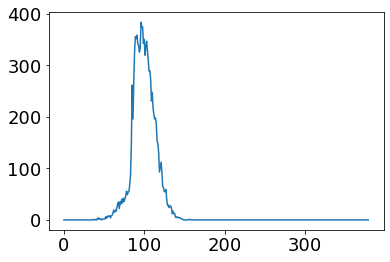

In [10]:
plt.plot(np.sum(np.array(intrinsic_r_tx114),axis=0))

In [4]:
np.mean(box_size)**(1/3)

118.88321817735977

In [ ]:
#save the profiles for plotting in the future so you don't have to recalculate...

# Plot calculated intrinsic density of the shell

/var/folders/mj/f780t1f175j8s3hb2g3mm24h0000gn/T/ipykernel_44000/2809649871.py:1: RuntimeWarning: invalid value encountered in true_divide
  intrinsic_density_profile_shell = intrinsic_r_tx114_profile/S_bar


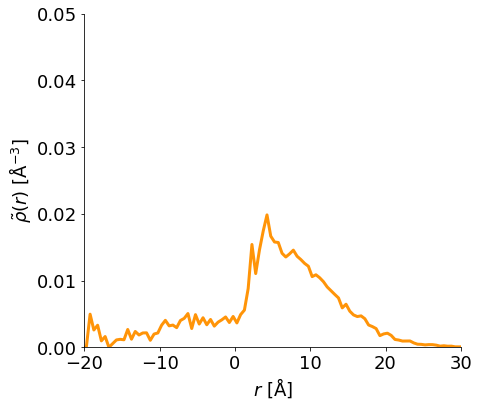

In [6]:
intrinsic_density_profile_shell = intrinsic_r_tx114_profile/S_bar

plt.rcParams.update({'font.size': 18})


fig=plt.figure(figsize=(7,6))
ax = plt.subplot(111)
plt.plot(np.arange(-40.25,149.75,0.5),intrinsic_density_profile_shell,lw=3,c="xkcd:tangerine")

plt.xlabel(r'$r \ [{\mathrm{\AA}}]$')
plt.ylabel(r'$\tilde{\rho}(r) \ [{\mathrm{\AA}^{-3}}]$')

plt.xlim(-20,30)
plt.ylim(0,0.05)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
# plt.savefig('intrinsic_density_tx114.pdf')
plt.show()

In [85]:
micelle = u.select_atoms('resname TX4 and name C1D C1C C1B C1A C1E C1F C2 C3A C3B C4 C5 C6C C6B C6A and prop mass ==12.011')
shell = u.select_atoms('resname TX4 and not name C1D C1C C1B C1A C1E C1F C2 C3A C3B C4 C5 C6C C6B C6A and prop mass ==12.011')

xyz_bin = stats.binned_statistic_dd(micelle.positions,micelle.positions,
                                    bins=[np.arange(0,u.dimensions[0]+0.1,2),np.arange(0,u.dimensions[1]+0.1,2),np.arange(0,u.dimensions[2]+0.1,2)],
                                    statistic='count').statistic


In [108]:
np.where(xyz_bin>0)

(array([   0,    0,    0, ..., 2099, 2099, 2099]),
 array([ 0,  0,  0, ..., 45, 58, 58]),
 array([34, 34, 35, ..., 33, 34, 35]),
 array([29, 31, 28, ..., 30, 30, 30]))

In [94]:
np.nonzero(xyz_bin)[0,(len(np.arange(0,u.dimensions[0]+0.1,2))**3)



((array([   0,    0,    0, ..., 2099, 2099, 2099]),
  array([ 0,  0,  0, ..., 45, 58, 58]),
  array([34, 34, 35, ..., 33, 34, 35]),
  array([29, 31, 28, ..., 30, 30, 30])),
 216000)

In [67]:
(np.sum(xyz_bin>0)/(np.shape(xyz_bin)[0]**3))*(u.dimensions[0]*u.dimensions[1]*u.dimensions[2])

798.9524604308391

In [52]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [83]:
hull = ConvexHull(micelle.positions)

In [84]:
hull.volume

118828.72514257349

In [ ]:
plt.plot(points[:,0], points[:,1], 'o')